In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import util
import models

from os.path import expanduser
from os import path
import logging

# logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config, preprocess
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot

Using TensorFlow backend.


In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 5

In [7]:
# explorer for standarized data
re = RecordingExplorer(path_to_standarized,
                       path_to_geom=path_to_geom,
                       n_channels=49,
                       spike_size=10,
                       neighbor_radius=70,
                       dtype='float32',
                       data_order='samples')

# compute templates for ground truth
se = SpikeTrainExplorer(gt, re)

## Inspecting ground truth amplitudes and templates

In [8]:
def spike_amplitudes_from_spikes(spikes):
    abs_value = np.abs(spikes)
    
    amplitudes = np.max(abs_value, axis=(1, 2))
    main_channels = np.argmax(np.max(abs_value, axis=1), axis=1)

    return amplitudes, main_channels

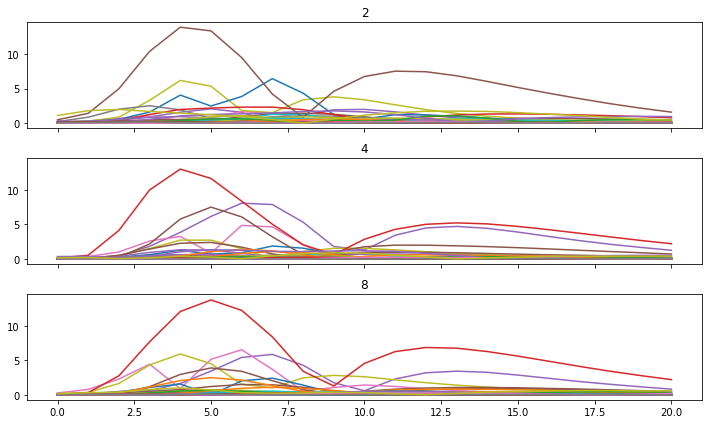

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
plot.grid(np.abs(se.templates), axis=0, elements=[2, 4, 8])

In [10]:
templates = np.copy(se.templates)
templates = np.concatenate((templates, np.zeros((49, 21, 1))), axis=2)

In [11]:
amps, main_channels = spike_amplitudes_from_spikes(se.templates)

In [12]:
print(amps[2], main_channels[2])

13.871453 25


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


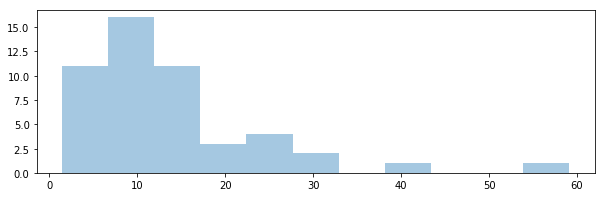

In [13]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps, kde=False)

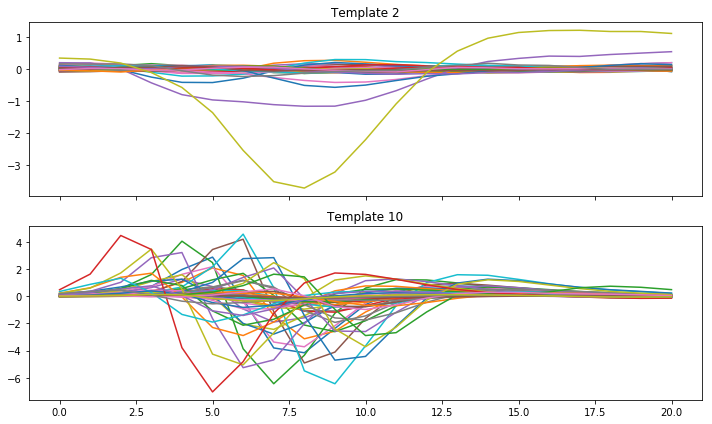

In [14]:
# this looks wrong
plt.rcParams['figure.figsize'] = (10, 6)
se.plot_templates(group_ids=[2, 10])

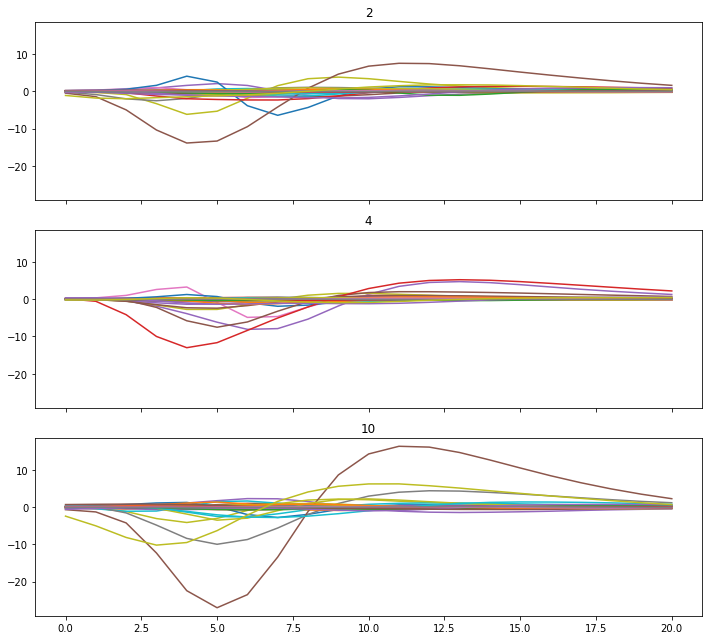

In [15]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid(se.templates, axis=0, elements=[2, 4, 10])

In [16]:
from yass.geometry import make_channel_index

In [17]:
ch_index = make_channel_index(re.neigh_matrix, re.geom)

In [18]:
n_templates, waveform_length, n_channels = templates.shape

small_templates = np.empty((n_templates, waveform_length, 7))

for i in range(n_templates):
    main_channel = main_channels[i]
    neighbors = ch_index[main_channel]
    small_templates[i] = templates[i][:, neighbors]

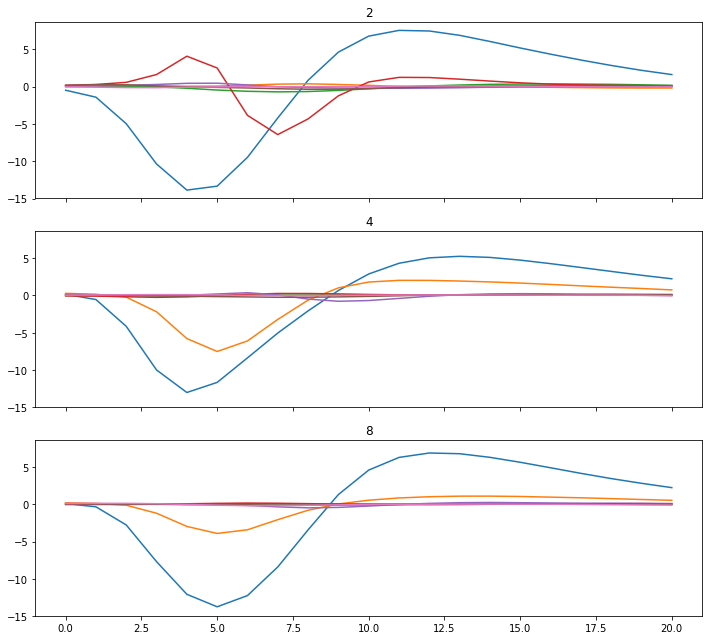

In [19]:
plt.rcParams['figure.figsize'] = (10, 9)
plot.grid(small_templates, axis=0, elements=[2, 4, 8])

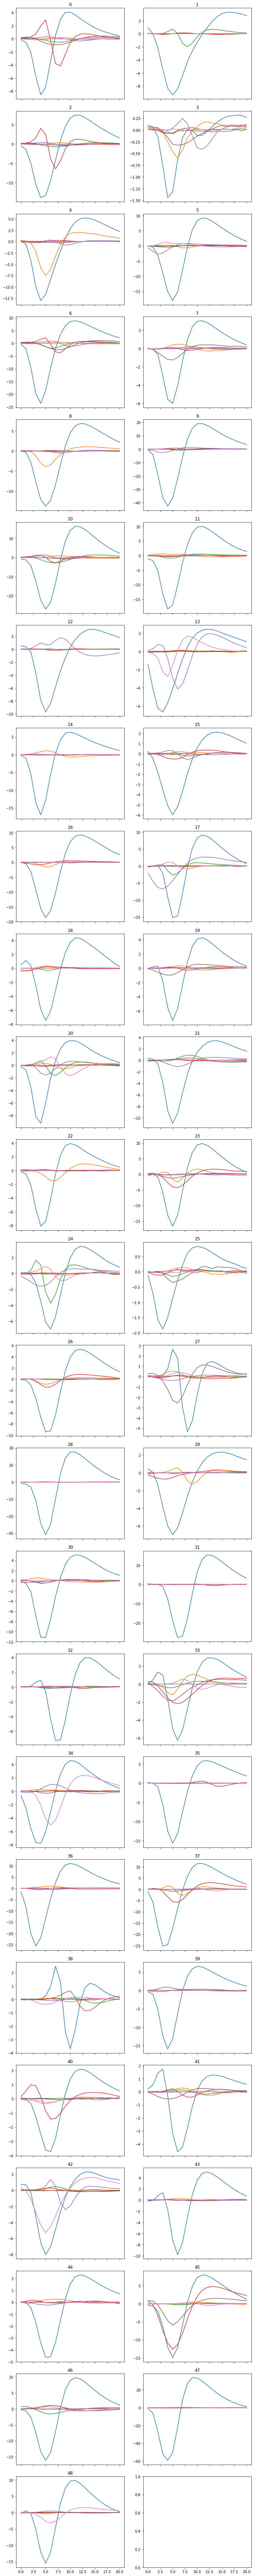

In [20]:
plt.rcParams['figure.figsize'] = (10, 100)
plot.grid(small_templates, axis=0, max_cols=2, sharey=False)

## Generating training data

In [21]:
min_amplitude = 5
n_spikes = 50000
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [22]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_spikes,
                                  data_folder='/home/Edu/data/nnet/')

100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


In [23]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(650052, 21, 7)
	triage:(150012, 21, 7)
	autoencoder:(747282, 21)


In [25]:
# compute amplitude for positive and negative samples in the detect training set
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

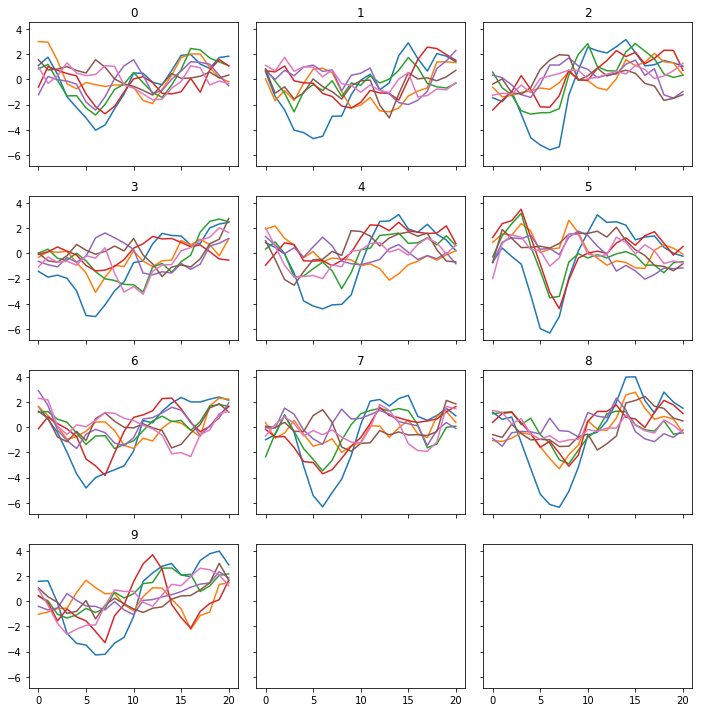

In [50]:
plot.grid(x_detect_positive, axis=0, elements=range(10))

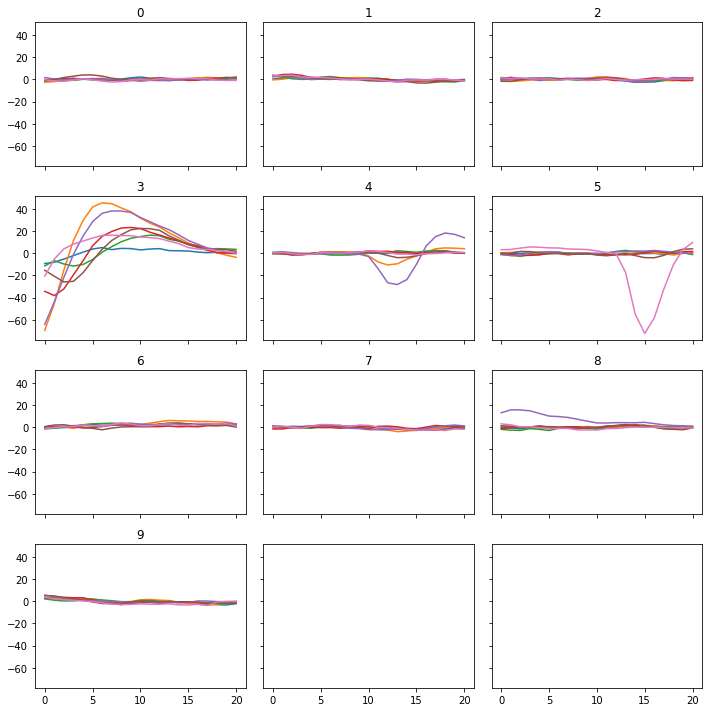

In [51]:
plot.grid(x_detect_negative, axis=0, elements=range(10))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


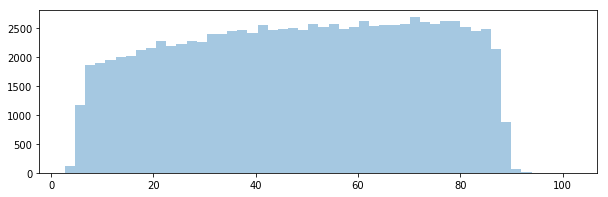

In [26]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_positive, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


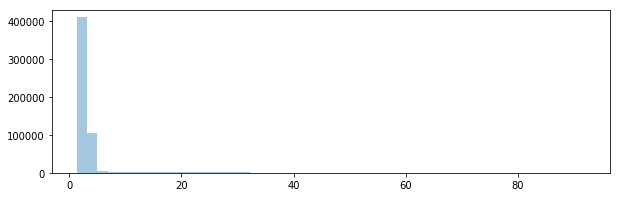

In [27]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_negative, kde=False)

In [44]:
x_triage_positive = x_triage[y_triage == 1]
x_triage_negative = x_triage[y_triage == 0]

In [47]:
print(x_triage_positive.shape, x_triage_negative.shape)

(50004, 21, 7) (100008, 21, 7)


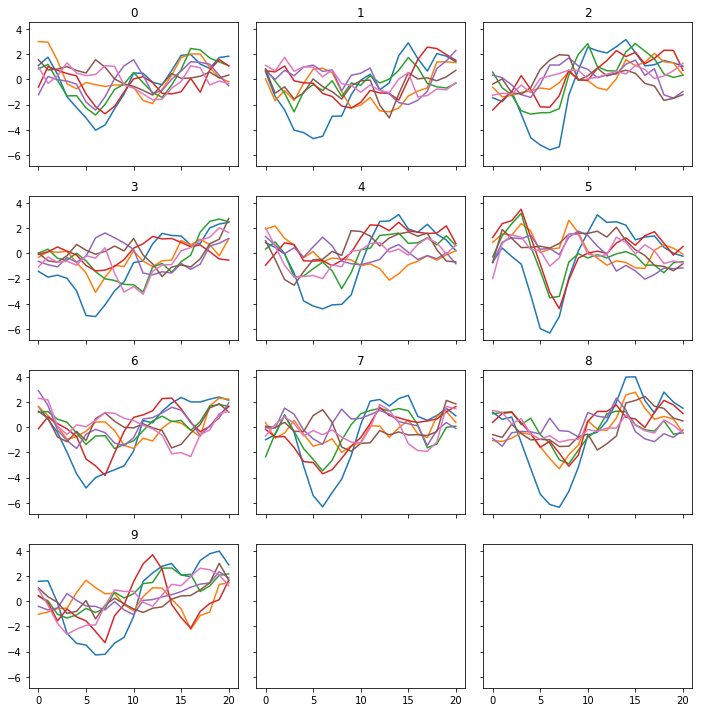

In [48]:
plot.grid(x_triage_positive, axis=0, elements=range(10))

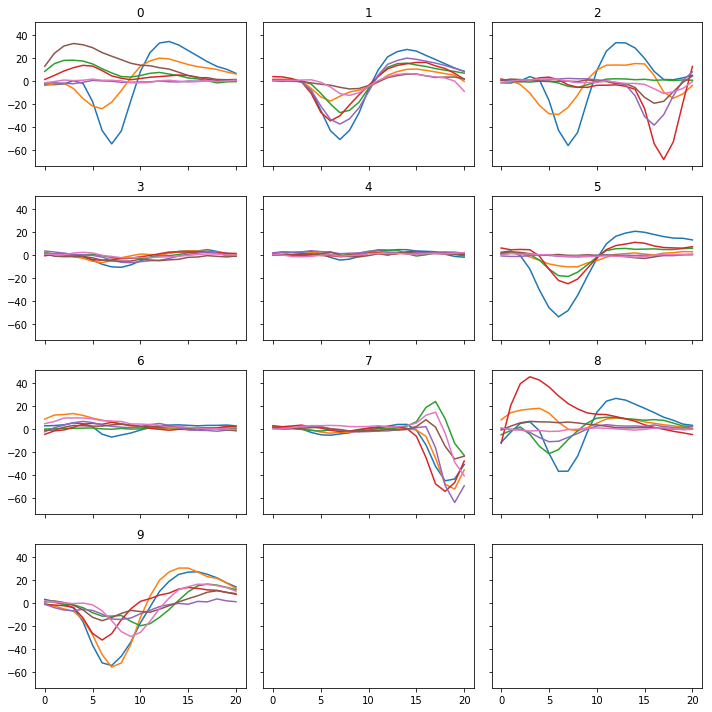

In [49]:
plot.grid(x_triage_negative, axis=0, elements=range(10))

# Training

In [28]:
n_iter = 5000

## Detector training

In [29]:
detect_name = path.join('models', 'detect-'+util.directory()+'.ckpt')
filters_detect = [8, 4]

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

Loss: 0.00013902383: 100%|██████████| 5000/5000 [01:25<00:00, 58.31it/s]


## Triage training

In [30]:
triage_name = path.join('models', 'triage-'+util.directory()+'.ckpt')
filters_triage = [8, 4]

_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage)

Loss: 0.2519432:   0%|          | 0/5000 [00:15<?, ?it/s]


 87%|████████▋ | 4363/5000 [00:30<00:04, 144.29it/s]


100%|██████████| 5000/5000 [00:34<00:00, 144.18it/s]

# Predict

In [31]:
output_dir = 'tmp/'

(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

In [32]:
explorer_std = RecordingExplorer(path_to_standarized,
                                 path_to_geom=None,
                                 spike_size=15, neighbor_radius=70)

In [33]:
_data = explorer_std.reader.data
window_size = 10000
idx = gt[105963, 0]
data = _data[idx-window_size:idx+window_size, :]

## Detect predict

In [34]:
output_names = ('spike_index', 'waveform', 'probability')

(spike_index, waveform,
 proba) = detector.predict(data, output_names=output_names)

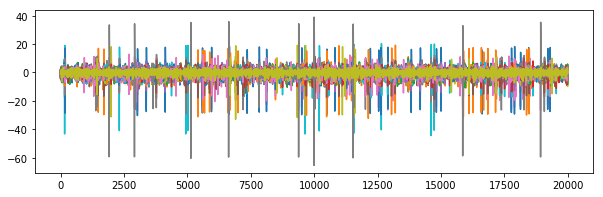

In [35]:
_ = plt.plot(data)

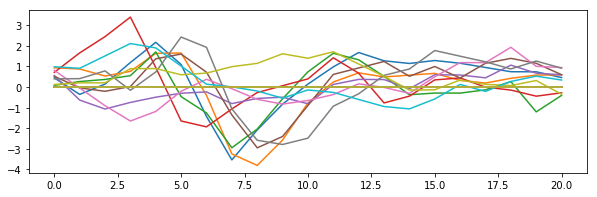

In [36]:
_ = plt.plot(waveform[0, :])

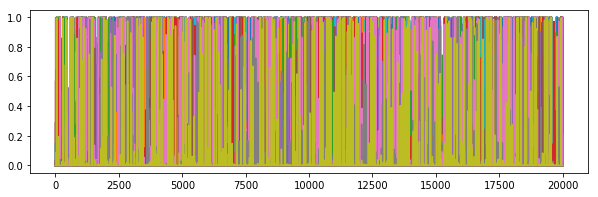

In [37]:
_ = plt.plot(proba)

## Triage predict

In [38]:
# to_triage = waveform[:, :, :x_triage.shape[2]]
to_triage = small_templates

In [39]:
idx_clean = triage.predict(to_triage)

In [40]:
not_clean = np.where(~idx_clean)[0]

In [41]:
not_clean

array([27, 38, 42])

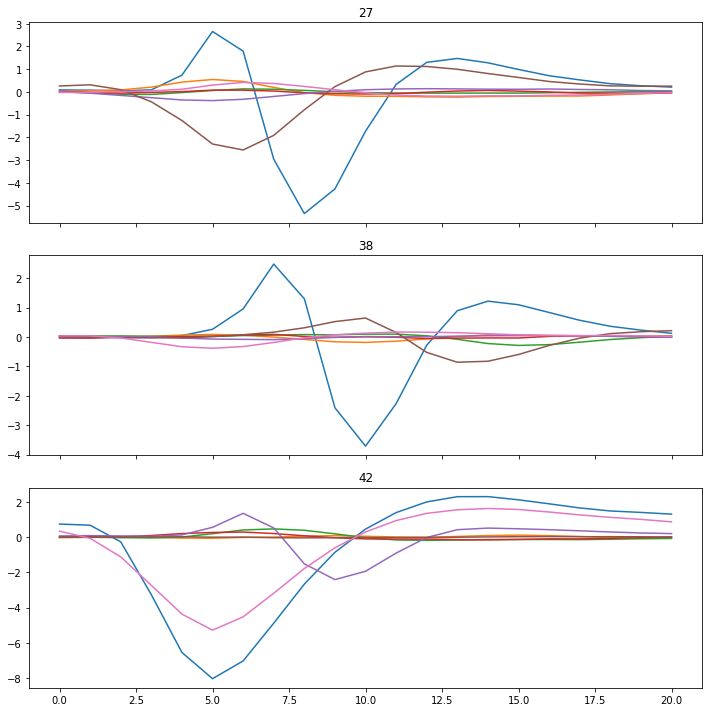

In [42]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid(small_templates, axis=0, elements=not_clean, sharey=False)